In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

In [2]:
chi2_data = ascii.read('/Users/yaolun/bhr71/hyperion/chi2_grid/chi2-2d.txt')

### Find the grid points in two axe

In [34]:
col_name = chi2_data.colnames
prob = np.exp(-chi2_data['chisq']/2)
p1 = np.array(list(set(chi2_data[col_name[1]])))
p2 = np.array(list(set(chi2_data[col_name[2]])))

### Function to return the fitted peak and width

In [55]:
def fit(x, y):
    from scipy.optimize import curve_fit

    # Define Gaussian
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [y.max(), np.median(x), x.max()-x.min()]
    
    coeff, var_matrix = curve_fit(gauss, x, y, p0=p0)
    
    return coeff[1], coeff[2]

### Get the uncertainty on p1 axis (iterating p2)

In [91]:
unc_p1 = np.zeros_like(p1)
for p in p2:
    x = chi2_data[col_name[1]][chi2_data[col_name[2]] == p]
    y = prob[chi2_data[col_name[2]] == p]

    try:
        val_dum, unc_dum = fit(x,y)
    except RuntimeError:
        print 'Gaussian cannot be fitted at %s degree row.' % p
        unc_dum = 0
    
    unc_p1[p2 == p] = abs(unc_dum)

Gaussian cannot be fitted at 53.0 degree row.


### Get the uncertainty on p2 axis (iterating p1)

In [92]:
unc_p2 = np.zeros_like(p2)
for p in p1:
    x = chi2_data[col_name[2]][chi2_data[col_name[1]] == p]
    y = prob[chi2_data[col_name[1]] == p]

    try:
        val_dum, unc_dum = fit(x,y)
    except RuntimeError:
        print 'Gaussian cannot be fitted at %s x 10^4 year column.' % p
        unc_dum = 0
    
    unc_p2[p1 == p] = abs(unc_dum)

Gaussian cannot be fitted at 2.4293 x 10^4 year column.
Gaussian cannot be fitted at 3.274 x 10^4 year column.


In [95]:
print p2
print unc_p1

print p1
print unc_p2

[ 57.  51.  53.  59.  55.]
[ 0.08967075  0.06037737  0.          0.09047491  0.10865768]
[ 3.0466  2.8309  2.6256  2.4293  3.274 ]
[ 0.74063618  0.64666857  0.75802383  0.          0.        ]


<Container object of 3 artists>

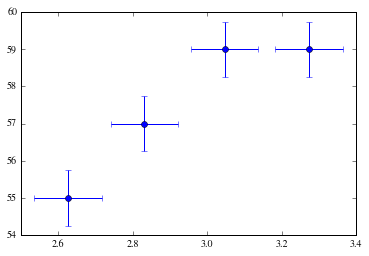

In [129]:
trimmer = (chi2_data['chisq'] < 20.2) & (chi2_data[col_name[2]] != 53.0)
xb = chi2_data[col_name[1]][trimmer]
yb = chi2_data[col_name[2]][trimmer]
# assign uncertainties
xerr = np.empty_like(xb)
yerr = np.empty_like(yb)

for x in xb:
    for y in yb:
        xerr[xb == x] = unc_p1[p2 == y]
        yerr[yb == y] = unc_p2[p1 == x]
        
        if xerr[xb == x][0] == 0:
            xerr[xb == x] = unc_p2[p1 == x]
        if yerr[yb == y][0] == 0:
            yerr[yb == y] = unc_p1[p2 == y]
        if xerr[xb == x][0]+yerr[yb == y][0] == 0:
            print x,y

plt.errorbar(xb, yb, xerr=xerr, yerr=yerr, fmt='o')

Beta: [  6.7817154   37.53276486]
Beta Std Error: [ 1.73640072  5.12926848]
Beta Covariance: [[  4.04589357 -11.9122243 ]
 [-11.9122243   35.30412122]]
Residual Variance: 0.745221640447
Inverse Condition #: 0.00387438478148
Reason(s) for Halting:
  Sum of squares convergence


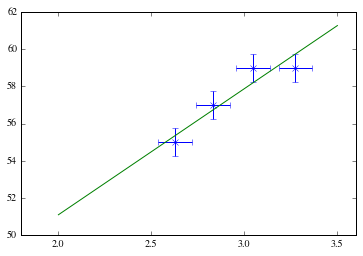

In [142]:
import scipy.odr as odr

# the fitted function
def linfunc(p, x):
    a, b = p
    return a*x + b

# create a model for fitting
lin_model = odr.Model(linfunc)

# create a RealData object
data = odr.RealData(xb, yb, sx=xerr, sy=yerr)

# set up ODR with the model and data
odr = odr.ODR(data, lin_model, beta0=[1., np.mean(y)])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

x_fit = np.linspace(2,3.5, 1000)
y_fit = linfunc(out.beta, x_fit)
y_fit_err = (out.cov_beta[0,0]+2*out.cov_beta[0,1]*x_fit+out.cov_beta[1,1]*x_fit**2)**0.5

plt.errorbar(xb, yb, xerr=xerr, yerr=yerr, linestyle='None', marker='x')
# plt.fill_between(x_fit, y_fit-y_fit_err, y_fit+y_fit_err, facecolor='Green', edgecolor='None', alpha=0.3)
plt.plot(x_fit, y_fit)

plt.show()


## Stackflow example of ODR

Beta: [ 0.99923458  0.50468293]
Beta Std Error: [ 0.00073699  0.01465223]
Beta Covariance: [[ 0.00054595 -0.00874584]
 [-0.00874584  0.21579444]]
Residual Variance: 0.000994872099653
Inverse Condition #: 0.245868592532
Reason(s) for Halting:
  Sum of squares convergence


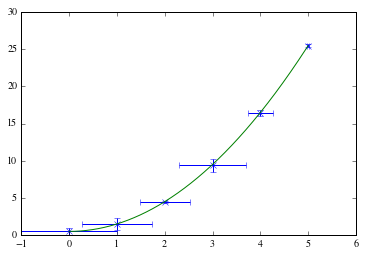

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *

import random

# Initiate some data, giving some randomness using random.random().
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([i**2 + random.random() for i in x])

x_err = np.array([random.random() for i in x])
y_err = np.array([random.random() for i in x])

# Define a function (quadratic in our case) to fit the data with.
def quad_func(p, x):
     m, c = p
     return m*x**2 + c

# Create a model for fitting.
quad_model = Model(quad_func)

# Create a RealData object using our initiated data from above.
data = RealData(x, y, sx=x_err, sy=y_err)

# Set up ODR with the model and data.
odr = ODR(data, quad_model, beta0=[0., 1.])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()
'''Beta: [ 1.01781493  0.48498006]
Beta Std Error: [ 0.00390799  0.03660941]
Beta Covariance: [[ 0.00241322 -0.01420883]
 [-0.01420883  0.21177597]]
Residual Variance: 0.00632861634898189
Inverse Condition #: 0.4195196193536024
Reason(s) for Halting:
  Sum of squares convergence'''

x_fit = np.linspace(x[0], x[-1], 1000)
y_fit = quad_func(out.beta, x_fit)

plt.errorbar(x, y, xerr=x_err, yerr=y_err, linestyle='None', marker='x')
plt.plot(x_fit, y_fit)

plt.show()
